# Sequential data modeling

In this example, we create a 1D convolutional and an LSTM network to predict a time series composed of noisy, automatically generated sine, cosine, logarithmic, and absolute value functions. The time series is split into windows of size window_size, which serve as inputs, and the output is the value that immediately follows each window.

In [ ]:
# !python -m venv tf_env
# !source tf_env/bin/activate

In [ ]:
# !pip3 install numpy scipy tensorflow keras scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 MB 2.6 MB/s eta 0:00:0000:0100:02
  Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 3.9 MB/s eta 0:00:0000:0100:01
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9

In [3]:
import numpy as np
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

We generate the raw time series data and visualize it:



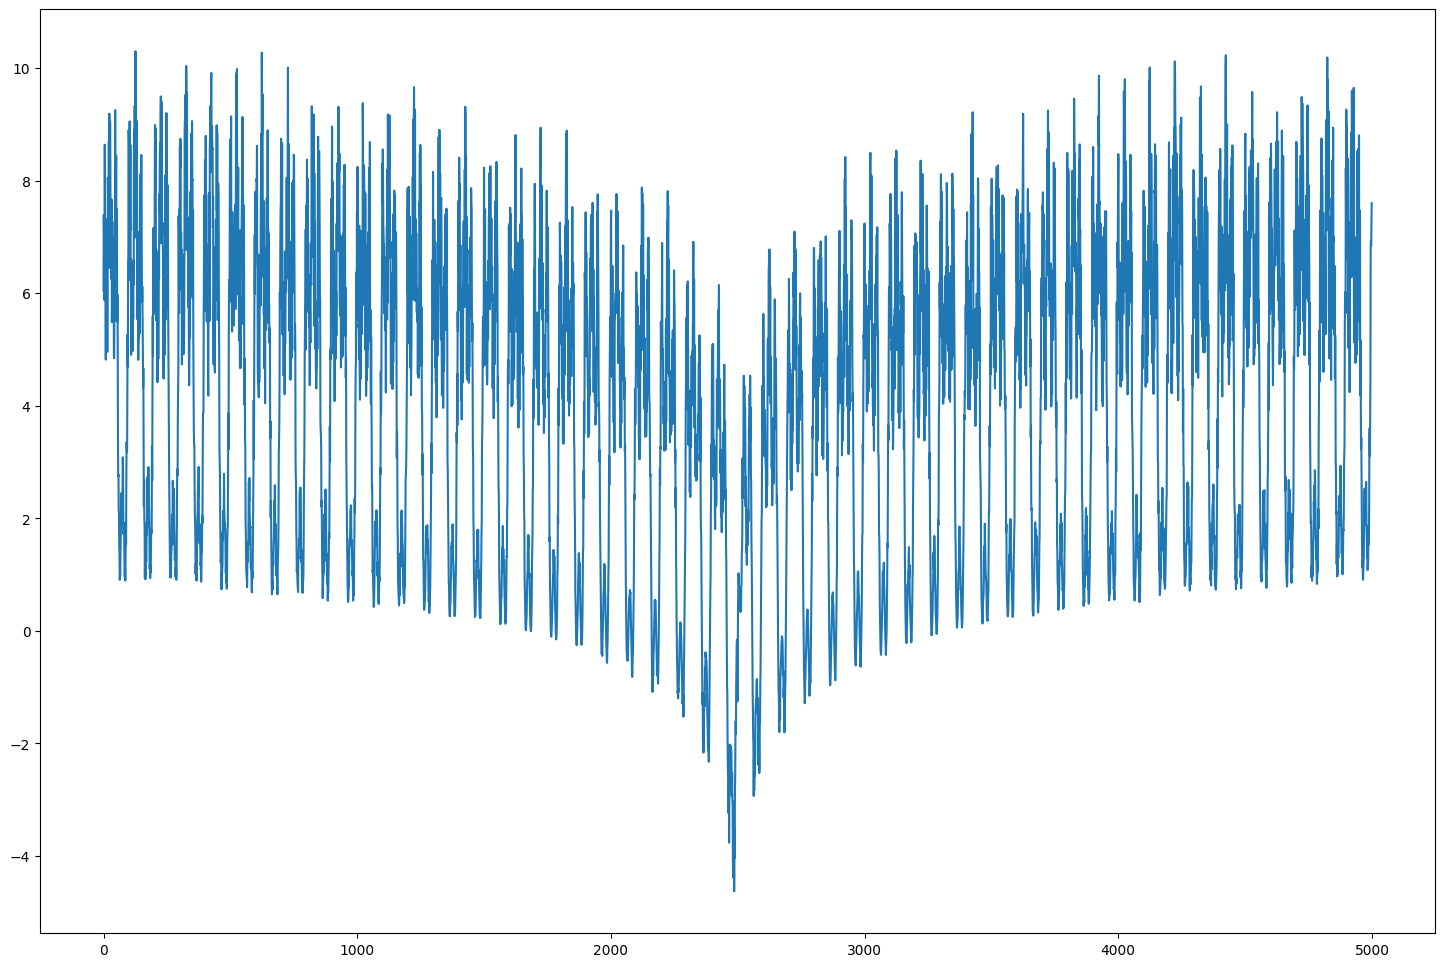

In [4]:
lp = np.linspace(-50*np.pi, 50*np.pi, 5000)
data = (1+((np.random.rand(5000)-0.5))/2)*((np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2 + lp*4)*1.5 + np.log(np.abs(lp))))
plt.figure(figsize=(18,12))
plt.plot(data)

We prepare the data for processing in the usual way:



In [5]:
test_split = 0.1
valid_split = 0.2

window_size = 20

data = np.asarray(data)


# TODO: Create the X variable, which should be a NumPy array.
# Each element should be a window of length 'window_size' from the time series.
# Step size is 1
X = np.array([data[i:i+window_size] for i in range(len(data)-window_size)])
# TODO: Create the Y variable to store the target values.
# The values should be the next elementes after the window_size long windows of X
Y = np.array([data[i+window_size] for i in range(len(data)-window_size)])

print(X.shape)
print(Y.shape)

t_length = int(len(X)*(1-test_split))
v_length = int(len(X)*(1-test_split-valid_split))

X_train = X[0:v_length]
Y_train = Y[0:v_length]
X_valid = X[v_length:t_length]
Y_valid = Y[v_length:t_length]
X_test = X[t_length:]
Y_test = Y[t_length:]

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = np.atleast_3d(scaler.transform(X_train))
X_valid = np.atleast_3d(scaler.transform(X_valid))
X_test = np.atleast_3d(scaler.transform(X_test))

(4980, 20)
(4980,)


# 1D CNN
Next, we create the 1D convolutional model, train it, and then run a prediction on the test data:

In [7]:
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights.keras', save_best_only=True, verbose=1)

model = Sequential()
# TODO: Add a 1D convolutional layer with 4 filters, kernel size 5, and ReLU activation.
# Set the input shape according to your data
# Hint: model.add(Conv1D(...))
model.add(Conv1D(filters=4, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# TODO: Add a 1D max pooling layer to reduce the temporal dimension
model.add(MaxPooling1D(pool_size=2))

# TODO: Add another 1D convolutional layer with the same parameters (4 filters, kernel size 5, ReLU activation)
model.add(Conv1D(filters=4, kernel_size=5, activation='relu'))

# TODO: Add another max pooling layer
model.add(MaxPooling1D(pool_size=2))

# TODO: Flatten the output so it can be fed into a Dense layer
model.add(Flatten())

# TODO: Add a dense (fully connected) layer with 1 neuron and linear activation for regression output
model.add(Dense(1, activation='linear'))


/Users/tdle26/Documents/Deep Learning/week9/tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 16, 4)          │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 4)           │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117 (468.00 B)

 Trainable params: 117 (468.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:

model.compile(loss='mse', optimizer='adam')

model.fit(X_train, Y_train, epochs=5000000, validation_data=(X_valid, Y_valid), verbose=2, callbacks=[early_stopping, checkpointer])

model = load_model('weights.keras')
preds = model.predict(X_test)

Epoch 1/5000000

Epoch 1: val_loss improved from inf to 10.59875, saving model to weights.keras
109/109 - 1s - 6ms/step - loss: 17.1665 - val_loss: 10.5988
Epoch 2/5000000

Epoch 2: val_loss improved from 10.59875 to 4.85889, saving model to weights.keras
109/109 - 0s - 1ms/step - loss: 6.4532 - val_loss: 4.8589
Epoch 3/5000000

Epoch 3: val_loss improved from 4.85889 to 2.98164, saving model to weights.keras
109/109 - 0s - 2ms/step - loss: 4.0871 - val_loss: 2.9816
Epoch 4/5000000

Epoch 4: val_loss improved from 2.98164 to 1.90668, saving model to weights.keras
109/109 - 0s - 1ms/step - loss: 2.5620 - val_loss: 1.9067
Epoch 5/5000000

Epoch 5: val_loss improved from 1.90668 to 1.51215, saving model to weights.keras
109/109 - 0s - 1ms/step - loss: 1.8699 - val_loss: 1.5121
Epoch 6/5000000

Epoch 6: val_loss improved from 1.51215 to 1.34565, saving model to weights.keras
109/109 - 0s - 2ms/step - loss: 1.5361 - val_loss: 1.3456
Epoch 7/5000000

Epoch 7: val_loss improved from 1.34565 t

Finally, we visualize the original and the predicted signals:

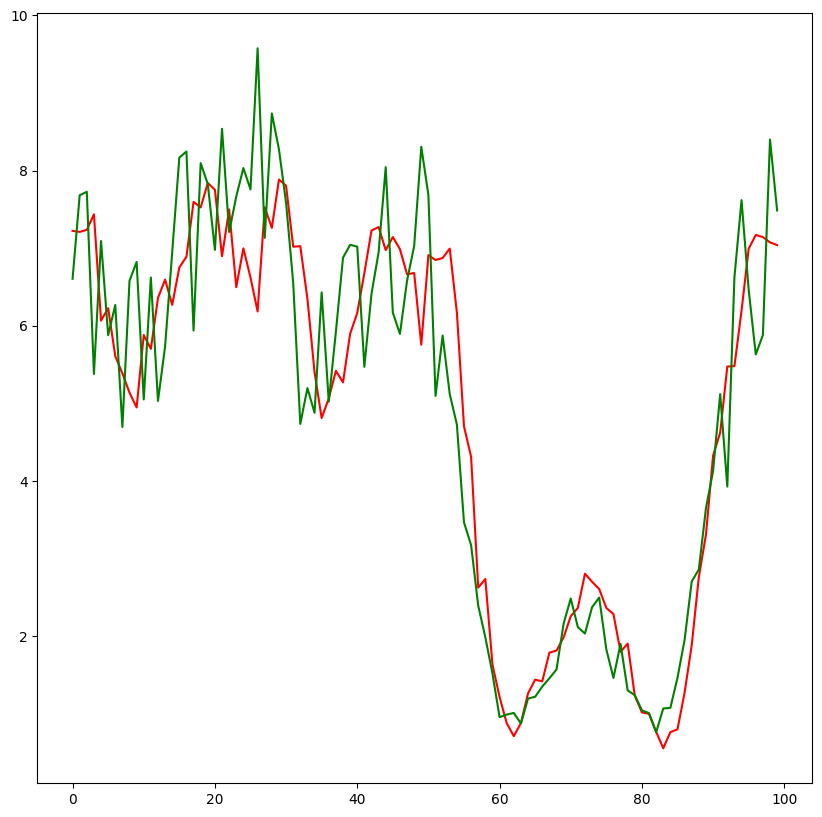

In [10]:
plt.figure(figsize=(10,10))
plt.plot(preds[:100], color='r')
plt.plot(Y_test[:100], color='g')

# LSTM


In [11]:
from keras.layers import LSTM

In [12]:
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

model_lstm = Sequential()
# TODO: Add an LSTM layer with 512 units.
# Make sure to set return_sequences=True, since another LSTM layer follows.
# Also, set input_shape=(20, 1)
model_lstm.add(LSTM(512, return_sequences=True, input_shape=(20, 1)))

# TODO: Add a second LSTM layer with 512 units.
# This is the last LSTM layer, so you don't need return_sequences here.
model_lstm.add(LSTM(512))

# TODO: Add a Dense layer with 1 output neuron and linear activation for regression.
model_lstm.add(Dense(1, activation='linear'))

/Users/tdle26/Documents/Deep Learning/week9/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,152,385 (12.03 MB)

 Trainable params: 3,152,385 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.fit(X_train, Y_train, epochs=5000000, validation_data=(X_valid, Y_valid), verbose=1, callbacks=[early_stopping, checkpointer])
preds = model_lstm.predict(X_test)


Epoch 1/5000000
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 7.0894
Epoch 1: val_loss did not improve from 0.87729
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - loss: 7.0514 - val_loss: 0.8781
Epoch 2/5000000
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.7895
Epoch 2: val_loss did not improve from 0.87729
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.7894 - val_loss: 1.0376
Epoch 3/5000000
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.7357
Epoch 3: val_loss improved from 0.87729 to 0.82699, saving model to weights.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.7356 - val_loss: 0.8270
Epoch 4/5000000
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.7144
Epoch 4: val_loss did not improve from 0.82699
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 0.7146 - val_loss: 0.8554
Epoch 5/5000000
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.7135
Epoch 5: val_loss improved from 0.82699 to 0.79482, saving model to weights.keras
109/109 ━━━━━

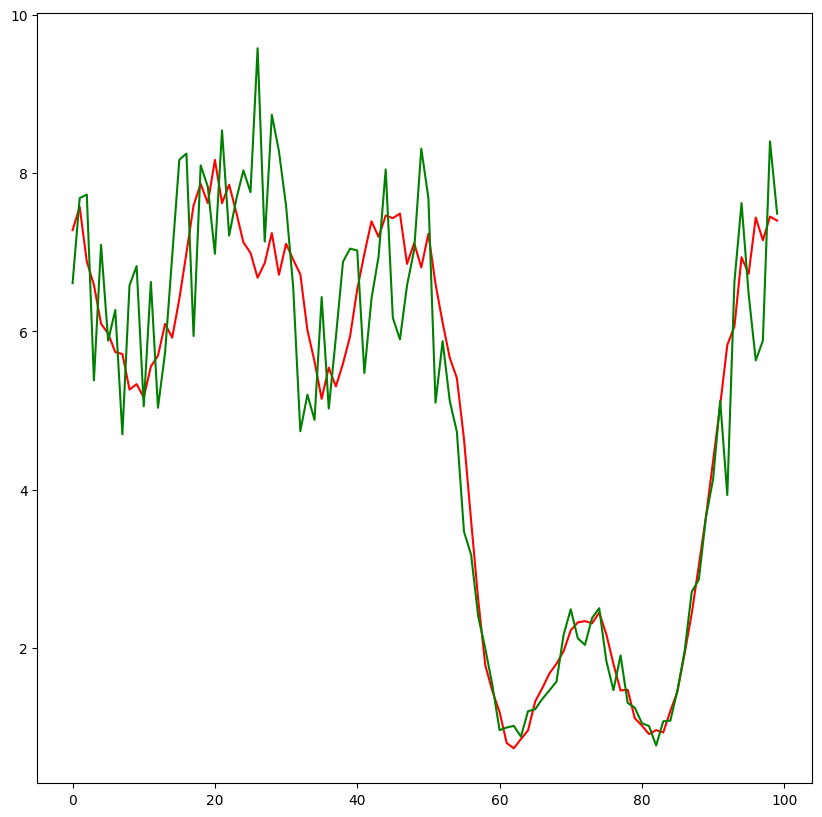

In [15]:
plt.figure(figsize=(10,10))
plt.plot(preds[:100], color='r')
plt.plot(Y_test[:100], color='g')